## Setup: 
Fork git repository and clone: https://github.com/gillespielab/gl-spyglass-tables

Setup conda/mamba environment as specified in https://github.com/LorenFrankLab/spyglass/blob/master/environment.yml

In [5]:
import datajoint as dj
import sys
import os

# Alternatively, uncomment these instead of using a dj_local_conf file
# dj.config['database.host'] = "" # enter datajoint host url
# dj.config['database.user'] = "" # enter datajoint username
# dj.config['database.port'] = 3306
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
dj.config.load("dj_local_conf.json")

from spyglass.common.common_behav import StateScriptFile
from spyglass.common.common_task import TaskEpoch
from spyglass.common.common_nwbfile import AnalysisNwbfile
sys.path.append("..")
from trial_info import TrialInfo

[2024-06-02 23:32:12,824][INFO]: Connecting molly@gl-ash.biostr.washington.edu:3306
[2024-06-02 23:32:12,854][INFO]: Connected molly@gl-ash.biostr.washington.edu:3306


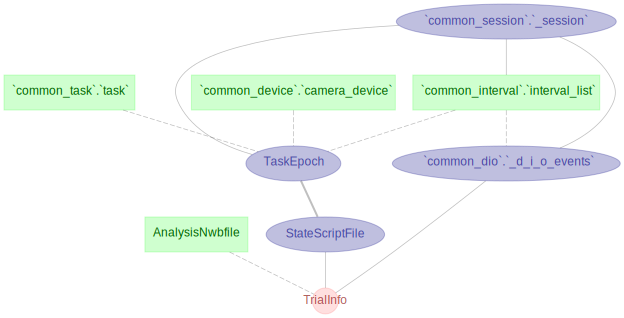

In [2]:
dj.Diagram(TaskEpoch) + dj.Diagram(TrialInfo) - 1

In [3]:
TrialInfo.heading

# 
nwb_file_name        : varchar(64)                  # name of the NWB file
epoch                : int                          # the session epoch for this task and apparatus(1 based)
dio_event_name       : varchar(80)                  # the name assigned to this DIO event
---
analysis_file_name   : varchar(64)                  # name of the file
trial_info_object_id : varchar(40)                  # the NWB object ID for loading this object from the file
parser               : varchar(100)                 # type of parser used to interpret statescript log
descriptors=null     : blob                         # global descriptors for task

In [7]:
TrialInfo()

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),dio_event_name the name assigned to this DIO event,analysis_file_name name of the file,trial_info_object_id the NWB object ID for loading this object from the file,parser type of parser used to interpret statescript log,descriptors global descriptors for task
archibald20210628_.nwb,2,homebeam,archibald20210628_NIG1A854IQ.nwb,06149fa7-059d-454c-9d09-530e6b256075,V8_delay,=BLOB=
archibald20210628_.nwb,4,homebeam,archibald20210628_ROVZ3G719I.nwb,17b586ab-5686-449c-8a6d-b3436f091c6d,V8_delay,=BLOB=
bobrick20231128_.nwb,2,homebeam,bobrick20231128_0X7WPJM3I6.nwb,46364e2d-83ee-4e12-a00f-880774dac960,V8_delay,=BLOB=
bobrick20231128_.nwb,4,homebeam,bobrick20231128_IOSLYF5N1K.nwb,cfe6d228-7c8d-4460-b8e8-c17ab8b7017b,V8_delay,=BLOB=
bobrick20231204_.nwb,2,homebeam,bobrick20231204_DVD9RJH3OK.nwb,a4891338-e78e-4ef9-8e3a-42f89356a7ef,V8_delay,=BLOB=
bobrick20231204_.nwb,4,homebeam,bobrick20231204_1IAHIJH04X.nwb,3df00258-8c8d-47fd-8ef9-398f0b263e85,V8_delay,=BLOB=
bobrick20231205_.nwb,2,homebeam,bobrick20231205_HGLGUKLF75.nwb,7ee2b2d1-77ea-49ef-8bd7-e460ec9dee6a,V8_delay,=BLOB=
bobrick20231205_.nwb,4,homebeam,bobrick20231205_DLQD553DDE.nwb,2df6fd4a-d258-495d-a9f1-81fa14eef33d,V8_delay,=BLOB=
chip20220101_.nwb,2,homebeam,chip20220101_X9LMXJJVAX.nwb,58eb330a-624f-4933-9d8e-832b5314d7c6,V8_delay,=BLOB=
herman20211114_.nwb,2,homebeam,herman20211114_C0Q1MQH0E4.nwb,d335091f-eda0-4989-97d7-b2603f1e71fd,V8_delay,=BLOB=


## Inserting epochs:
`TrialInfo.populate()` parses all StateScriptLog run sessions. Here, we we can also insert epochs from a single animal.

In [6]:
nwb_file_name = "bobrick20231205_.nwb"

In [5]:
TrialInfo.populate(StateScriptFile & {'nwb_file_name' : nwb_file_name})

[15:47:50][INFO] Spyglass: Skipping sleep epoch: bobrick20231204_.nwb, epoch 1
[15:47:51][INFO] Spyglass: Writing new NWB file bobrick20231204_VEUNTEK7TR.nwb
[15:47:53][INFO] Spyglass: Skipping sleep epoch: bobrick20231204_.nwb, epoch 3
[15:47:54][INFO] Spyglass: Writing new NWB file bobrick20231204_VP8WVUK9BP.nwb
[15:47:56][INFO] Spyglass: Skipping sleep epoch: bobrick20231204_.nwb, epoch 5


## Reading the resulting analysis file

In [8]:
# select a specific epoch for the inserted session
restr = {"nwb_file_name": nwb_file_name, "epoch": 2}

In [9]:
# accessing trial descriptors
(TrialInfo & restr).fetch1("descriptors")

{'statescript': 'V8pre_delay_locknoise_uw.sc',
 'lockout_period': 30.0,
 'python_script': 'V8.py',
 'outer_reps': [4, 13],
 'num_goals': 1,
 'forage_num': 1}

In [10]:
# fetching dataframe for the specified run epoch
df = (TrialInfo & restr).fetch1_dataframe()
df

,trial_num,start_time,end_time,leave_home,trial_type,rw_start,rw_end,leave_rw,rw_success,outer_well,goal_well,outer_time,leave_outer,outer_success,lockout_starts,lockout_ends,during_lockout,lockout_type
id,,,,,,,,,,,,,,,,,,
0,1,1.701801e+09,1.701801e+09,1.701801e+09,1,1.701801e+09,1.701801e+09,1.701801e+09,1,7.0,4.0,1.701801e+09,1.701801e+09,0,[],[],[],0
1,2,1.701801e+09,1.701801e+09,1.701801e+09,1,1.701801e+09,1.701801e+09,1.701801e+09,1,4.0,4.0,1.701801e+09,1.701801e+09,1,[],[],[],0
2,3,1.701801e+09,1.701801e+09,1.701801e+09,2,1.701801e+09,1.701801e+09,1.701801e+09,1,6.0,4.0,1.701801e+09,1.701801e+09,0,[],[],[],0
3,4,1.701801e+09,1.701802e+09,1.701801e+09,2,1.701801e+09,1.701801e+09,1.701802e+09,1,0.0,4.0,0.000000e+00,0.000000e+00,0,[1701801507.225482],[1701801537.225482],"[1, 1]",1
4,5,1.701802e+09,1.701802e+09,1.701802e+09,2,1.701802e+09,1.701802e+09,1.701802e+09,1,8.0,4.0,1.701802e+09,1.701802e+09,0,[],[],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,118,1.701806e+09,1.701806e+09,1.701806e+09,2,1.701806e+09,1.701806e+09,1.701806e+09,1,0.0,0.0,0.000000e+00,0.000000e+00,0,[1701806087.4964821],[1701806117.4964821],"[3, 4, 1, 1]",1
118,119,1.701806e+09,1.701807e+09,1.701806e+09,1,1.701806e+09,1.701806e+09,1.701806e+09,1,0.0,0.0,0.000000e+00,0.000000e+00,0,"[1701806175.955482, 1701806239.175482, 1701806...","[1701806205.955482, 1701806269.175482, 1701806...","[2, 1, 3, 1, 2, 1, 2, 1, 2, 1, 3, 1, 2, 11, 1,...",1
119,120,1.701807e+09,1.701807e+09,1.701807e+09,2,1.701807e+09,1.701807e+09,1.701807e+09,1,5.0,0.0,1.701807e+09,1.701807e+09,0,[],[],[],0


In [9]:
# vscode widget: run this cell to get an interactive plot
%matplotlib ipympl

# Uncomment this widget instead for jupyter notebook:
#%matplotlib notebook


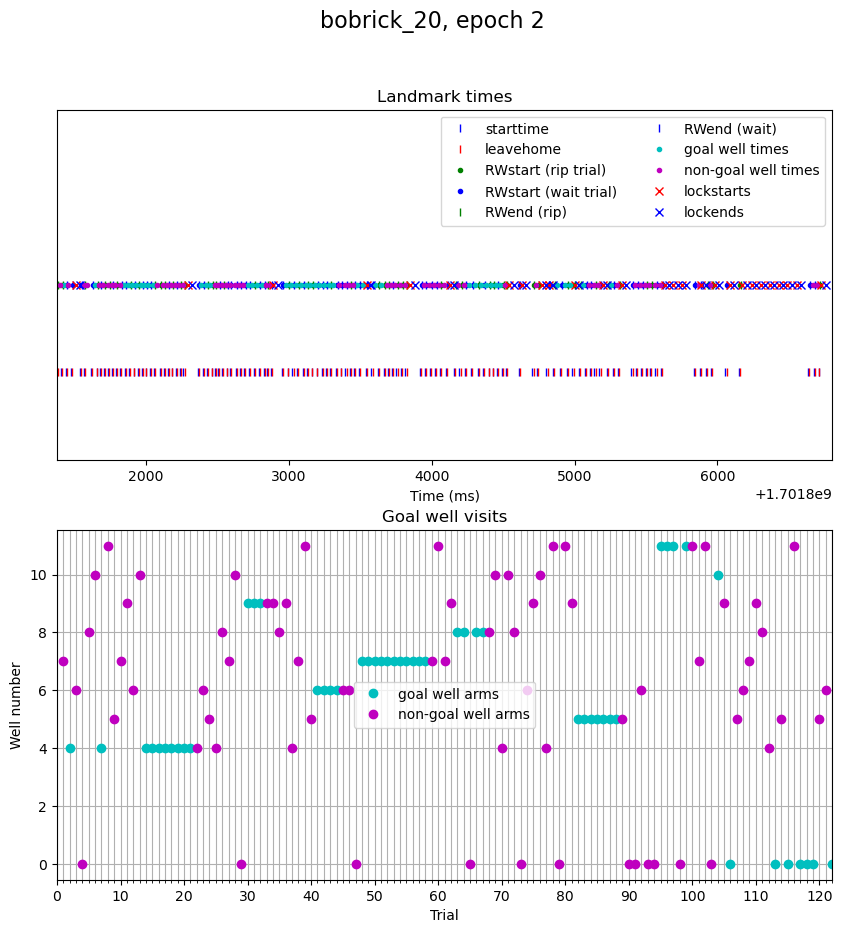

In [16]:
# optional: visualize landmark times during epoch
(TrialInfo & restr).plot_trials()

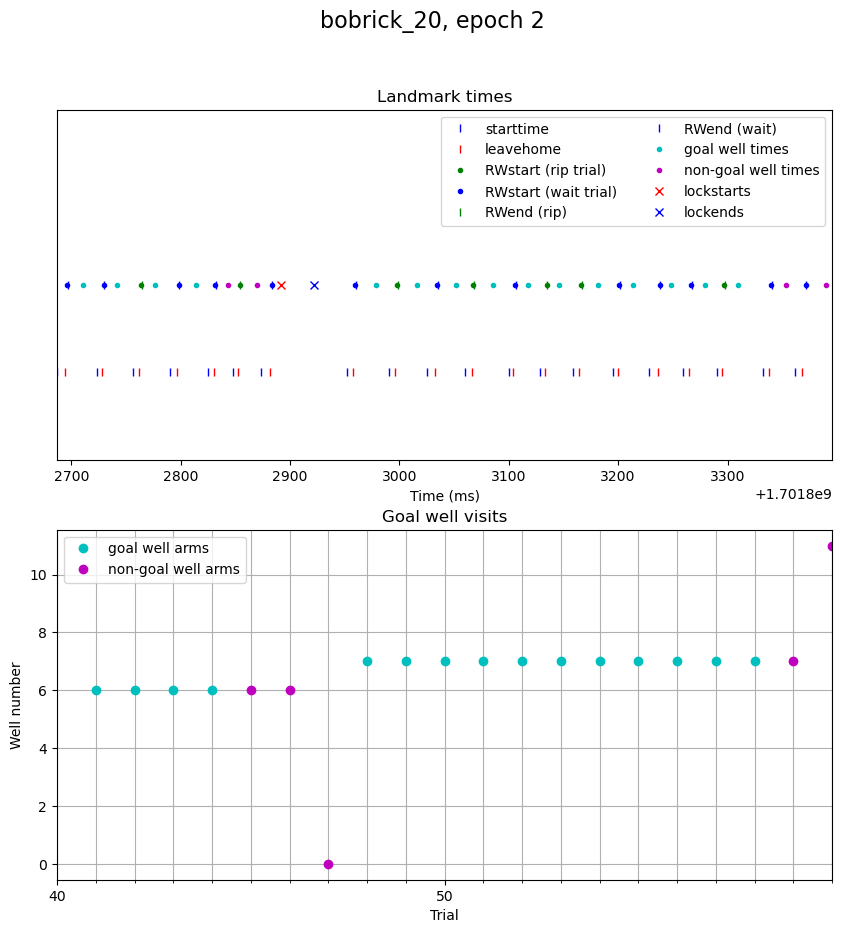

In [19]:
# alternatively, select a smaller interval of trials
(TrialInfo & restr).plot_trials(start=40, end=60)

### Sample analysis: calculating moving reward rates

Helper methods `get_goal_fractions` and `plot_goal_fractions` to visualize reward rate aligned to the most recent goal-change/reward trial

(ref https://www.sciencedirect.com/science/article/pii/S0896627321005730#fig1)

In [20]:
sys.path.append("..")
from utils.data_vis import plot_goal_fractions, get_goal_fractions

In [21]:
# processed data returned as dictionary of arrays; may be helpful for aggregating data from multiple epochs
data = get_goal_fractions(df)
data

{'goal_fraction_since_change': array([0.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
        0.16666667, 0.28571429, 0.25      , 0.22222222, 0.2       ,
        0.18181818, 0.16666667, 0.15384615, 0.21428571, 0.26666667,
        0.3125    , 0.35294118, 0.38888889, 0.42105263, 0.45      ,
        0.47619048, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.11111111,
        0.2       , 0.27272727, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.11111111, 0.2       , 0.27272727, 0.33333333, 0.        ,
        0.        , 0.        , 0.25      , 0.4       , 0.5       ,
        0.57142857, 0.625     , 0.66666667, 0.7       , 0.72727273,
        0.75      , 0.76923077, 0.78571429, 0.        , 0.        ,
        0.        , 0.        , 0.2       , 0.33333333, 0.28571429,
        0.375     , 0.44444444, 0.        , 0.        , 0.        ,
        0.        

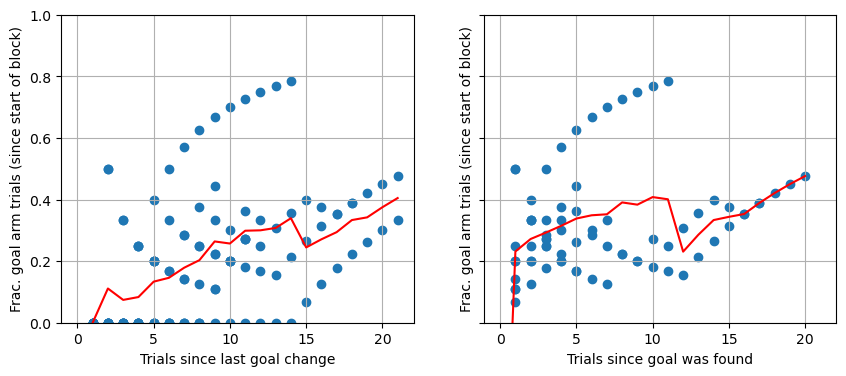

In [15]:
# alternatively, just view plots of single session
plot_goal_fractions(df)

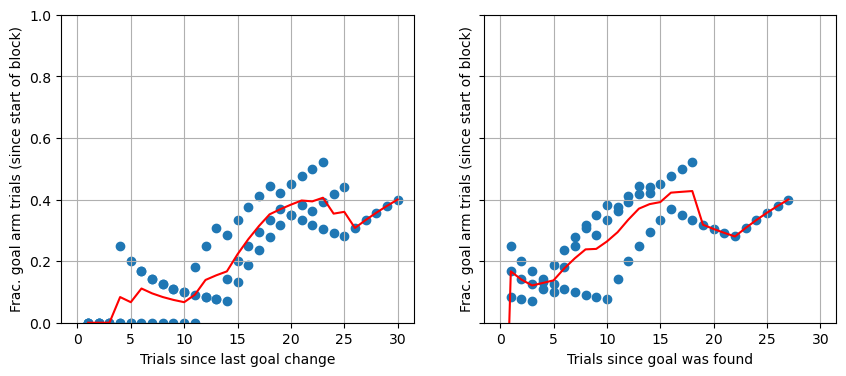

In [51]:
# let's try herman!
df_ep4 = (TrialInfo & {"nwb_file_name": "herman20211114_.nwb", "epoch": 4}).fetch1_dataframe()
plot_goal_fractions(df_ep4)

## Deleting Entries

In [14]:
# Deletes TrialInfo entries from this session
(TrialInfo & {"nwb_file_name" : nwb_file_name}).delete()

[15:46:51][INFO] Spyglass: Building merge cache for __trial_info.
	Found 0 downstream merge tables


[2024-05-22 15:46:51,583][INFO]: Deleting 2 rows from `trial_info`.`__trial_info`
[2024-05-22 15:46:53,661][INFO]: Deletes committed.


In [15]:
TrialInfo & {"nwb_file_name" : nwb_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),dio_event_name the name assigned to this DIO event,analysis_file_name name of the file,trial_info_object_id the NWB object ID for loading this object from the file,parser type of parser used to interpret statescript log,descriptors global descriptors for task


In [6]:
# Automatically deletes AnalysisNwbfile entries that are not referenced a downstream table
# AND removes the filepath entries for NWB files that are not in use.
AnalysisNwbfile.nightly_cleanup()

100%|██████████| 4/4 [00:00<00:00, 93.11it/s]
